<a href="https://colab.research.google.com/github/joongsukim/study_ai/blob/main/%EB%B0%A9%ED%83%84_%EC%86%8C%EB%85%84%EB%8B%A8_%EC%82%AC%EC%A7%84%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# vggnet 신경망 모델을 직접 생성하고 성능을 측정하기로 해보겠다 

In [3]:
import tensorflow as tf
import numpy as np 

내가 가지고 있는  데이터 셋을 이용해서 모델의 성능을 측정해보자 

google drive안에 저장해둔 bts 데이터 셋의 샘플 이미지들을 가져온다 

In [9]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


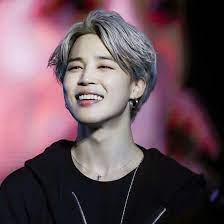

In [12]:
from IPython.display import Image
Image('/gdrive/My Drive/bts_test/1.jpeg')


bts dataset은 총 7명의 bts member들 각각 45장의 사진으로 이루어진 dataset이다 아직 정제되지 않은 dataset이므로 256,256으로 resize을 시켜준다



In [67]:
# 이미지 장수에 맞게 값을 변경하자 
# ylabel은 지민 -> 슈가 -> 뷔  -> 진 -> rm  -> 정국 -> 제이홉 순이다 
image_length = 315
test_size = 7
members_list = np.arange(0,7)
images_path ='/gdrive/My Drive/bts_test/'

In [68]:
import cv2 
image_w = 256
image_h = 256
  
X = []
Y = []
for i in range(1,316):
  image_path = images_path + str(i) + '.jpeg'
  try :
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize = (image_w,image_h))
  except :
    image_path = images_path + str(i) + '.png'
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize = (image_w,image_h))
  img = img / 256.0
  X.append(img)
  Y.append(members_list[(i-1)//45])
X = np.array(X)
Y = np.array(Y)
X = X.reshape(-1,256,256,3)


label은 숫자로 고쳐야하므로 one-hot code로 encoding하던가 unique한 숫자로 바꾸어야한다 하지만 이번에는 그냥 label을 숫자로 표시했다 

여기서 train과 test dataset을 나누어 보자 

In [69]:
# 가장 자주 쓰이는 sklearn library이다 shuffle = True로 무작위로 shuffle하게 할 수 있게 하였고 , random_state =1004로 지정해주어서 
# 나중에 재현 가능하게 해두었다 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.4,shuffle=True,random_state=1004)


In [70]:
# y_train 을 보아서 무작위로 흩어진 것을 확인할 수 있었다 
Y_train

array([0, 2, 6, 1, 0, 6, 4, 6, 0, 0, 5, 5, 4, 3, 0, 2, 2, 3, 6, 4, 3, 2,
       5, 5, 3, 4, 2, 0, 1, 1, 5, 5, 6, 6, 0, 1, 5, 3, 2, 6, 3, 6, 6, 5,
       1, 3, 1, 3, 5, 2, 6, 5, 1, 4, 5, 2, 6, 2, 3, 6, 5, 3, 2, 6, 1, 2,
       5, 5, 2, 3, 1, 6, 4, 4, 4, 3, 4, 4, 1, 1, 0, 1, 1, 1, 2, 3, 3, 5,
       5, 3, 1, 1, 6, 1, 1, 1, 6, 6, 1, 4, 5, 4, 3, 3, 6, 3, 3, 6, 4, 4,
       3, 5, 2, 1, 1, 3, 1, 3, 2, 5, 0, 2, 1, 6, 6, 3, 0, 2, 0, 5, 2, 1,
       5, 4, 2, 6, 0, 6, 6, 5, 3, 6, 2, 5, 6, 6, 2, 3, 0, 3, 3, 5, 1, 3,
       5, 5, 4, 6, 6, 6, 0, 2, 4, 0, 5, 0, 2, 0, 1, 1, 1, 4, 2, 0, 3, 2,
       2, 6, 4, 1, 1, 1, 4, 0, 4, 5, 0, 0, 0])

In [71]:
# vgg network을 사용해서 해당 모델을 학습할 것이다 
model = tf.keras.Sequential([
                       # 한번씩 할때마다 깊이는 더 깊어지는 대신 폴링층을 통해서 공간 차원은 반으로 줄게 된다 
                       tf.keras.layers.Conv2D(kernel_size=(3,3),input_shape=(256,256,3),filters=64),
                       tf.keras.layers.Conv2D(kernel_size=(3,3),filters=64),
                       tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2),

                       tf.keras.layers.Conv2D(kernel_size=(3,3),filters=128),
                       tf.keras.layers.Conv2D(kernel_size=(3,3),filters=128),
                       tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2),

                       tf.keras.layers.Conv2D(kernel_size=(3,3),filters=256),
                       tf.keras.layers.Conv2D(kernel_size=(3,3),filters=256),
                       tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2),

                       tf.keras.layers.Conv2D(kernel_size=(3,3),filters=512),
                       tf.keras.layers.Conv2D(kernel_size=(3,3),filters=512),
                       tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=2),

                       tf.keras.layers.Flatten(),
                       tf.keras.layers.Dense(units=2048, activation='relu'),
                       tf.keras.layers.Dropout(0.5),
                       tf.keras.layers.Dense(units=1024, activation='relu'),
                       tf.keras.layers.Dropout(0.5),
                       tf.keras.layers.Dense(units=512,activation='relu'),
                       tf.keras.layers.Dropout(0.5),
                       tf.keras.layers.Dense(units=10,activation='softmax')
])
model.compile(optimizer=tf.optimizers.Adam(),
             loss= 'sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 124, 124, 128)     73856     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 122, 122, 128)     147584    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 61, 61, 128)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 59, 59, 256)      

In [72]:
# 시간이 너무 오래 걸릴 것을 우려해서 epochs는 20으로 두었다 
# dataset의 크기가 얼마 없어서 batch_size도 10으로 두었다 
history = model.fit(X_train,Y_train, epochs= 20, validation_split=0.25, batch_size = 10)

Epoch 1/20
15/15 [==============================] - 233s 15s/step - loss: 168.9574 - accuracy: 0.1423 - val_loss: 43.1173 - val_accuracy: 0.1458
Epoch 2/20
15/15 [==============================] - 230s 15s/step - loss: 207.3369 - accuracy: 0.1829 - val_loss: 506.8598 - val_accuracy: 0.1458
Epoch 3/20
15/15 [==============================] - 223s 15s/step - loss: 262.7302 - accuracy: 0.1221 - val_loss: 12.3450 - val_accuracy: 0.1250
Epoch 4/20
15/15 [==============================] - 223s 15s/step - loss: 21.1934 - accuracy: 0.1747 - val_loss: 15.3226 - val_accuracy: 0.1250
Epoch 5/20
15/15 [==============================] - 232s 16s/step - loss: 14.0608 - accuracy: 0.1863 - val_loss: 2.6755 - val_accuracy: 0.1875
Epoch 6/20
15/15 [==============================] - 225s 15s/step - loss: 3.9254 - accuracy: 0.1878 - val_loss: 2.2022 - val_accuracy: 0.1667
Epoch 7/20
15/15 [==============================] - 223s 15s/step - loss: 2.4261 - accuracy: 0.1863 - val_loss: 2.0263 - val_accuracy: 

학습을 시켜본 결과 30퍼 정도의 정확도를 가지게 되었다. 아마도 샘플 이미지의 크기가 작고 epoch의 수도 작아서 그런듯하다 

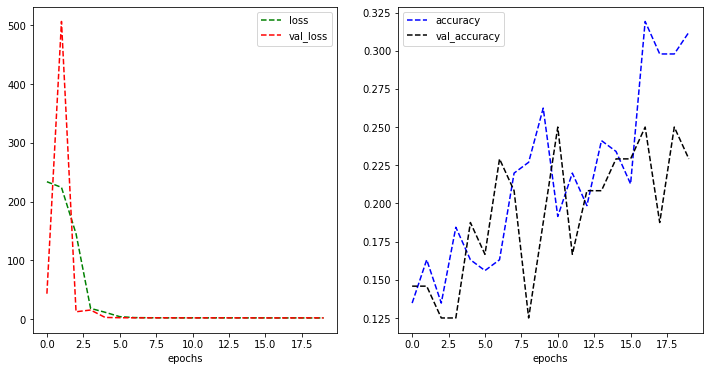

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],'g--',label='loss')
plt.plot(history.history['val_loss'],'r--',label='val_loss')
plt.xlabel('epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],'b--',label='accuracy')
plt.plot(history.history['val_accuracy'],'k--',label='val_accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

# 그럼 이제 기존에 훈련된 모델을 그대로 가져와서 마지막의 가중치만 바꾸는 전이학습을 이용해서 학습률을 최대한 올려보자

사용할 네트워크는 image 분류에서 탁월한 성능을 가진 Mobilenet V2이다 
input이 다르므로 미리 바꾸어주자 
(256,256,3) image를 (224,224,3)으로 reshape하는 것은 힘들거 같아서 그냥 새로 생성해주었다 

In [103]:
image_w = 224
image_h = 224
X = []
Y = []
for i in range(1,316):
  image_path = images_path + str(i) + '.jpeg'
  try :
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize = (image_w,image_h))
  except :
    image_path = images_path + str(i) + '.png'
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize = (image_w,image_h))
  img = img / 224.0
  X.append(img)
  Y.append(members_list[(i-1)//45])
X = np.array(X)
Y = np.array(Y)
X = X.reshape(-1,224,224,3)

In [104]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.4,shuffle=True,random_state=1004)

In [106]:
from tensorflow.keras.applications import MobileNetV2
from keras.layers import Input
mobilev2 = MobileNetV2()

어떤 구조로 이루어져있는지 간략하게만 살펴 보자 

In [107]:
mobilev2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

위의 구조를 살펴보면 확실히 학습할 parameter가 vggnet의 parameter보다는 작은 것을 확인 가능하다 
이제 기존의 학습된 모델에서 일부 layer을 없애서 우리가 원하는 모델로 바꾸어보자 

In [109]:
# 함수형으로 모델을 정의한다 
x = mobilev2.layers[-2].output
# 방탄소년단 멤버수가 7이기에 바꾸어준다 
prediction = tf.keras.layers.Dense(7,activation='softmax')(x)
model = tf.keras.Model(inputs=mobilev2.input, outputs= prediction)

for layer in model.layers[:-20]:
  layer.trainable = False
for layer in model.layers[-20:]:
  layer.trainable = True

model.compile(optimizer ='sgd', loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()



Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

이제 똑같은 조건으로 학습을 시켜서 vggnet과의 비교를 해보자 

In [110]:
history = model.fit(X_train,Y_train, epochs= 20, validation_split=0.25, batch_size = 10)

Epoch 1/20
15/15 [==============================] - 12s 618ms/step - loss: 1.9963 - accuracy: 0.1993 - val_loss: 2.0940 - val_accuracy: 0.2083
Epoch 2/20
15/15 [==============================] - 8s 558ms/step - loss: 0.9996 - accuracy: 0.6879 - val_loss: 1.9642 - val_accuracy: 0.2500
Epoch 3/20
15/15 [==============================] - 8s 563ms/step - loss: 0.4074 - accuracy: 0.9282 - val_loss: 1.9734 - val_accuracy: 0.2708
Epoch 4/20
15/15 [==============================] - 8s 565ms/step - loss: 0.2797 - accuracy: 0.9918 - val_loss: 1.4967 - val_accuracy: 0.4583
Epoch 5/20
15/15 [==============================] - 8s 561ms/step - loss: 0.3690 - accuracy: 0.9068 - val_loss: 1.5127 - val_accuracy: 0.4583
Epoch 6/20
15/15 [==============================] - 8s 566ms/step - loss: 0.2362 - accuracy: 0.9779 - val_loss: 1.6581 - val_accuracy: 0.3750
Epoch 7/20
15/15 [==============================] - 8s 564ms/step - loss: 0.2231 - accuracy: 0.9754 - val_loss: 2.0529 - val_accuracy: 0.3750
Epoch

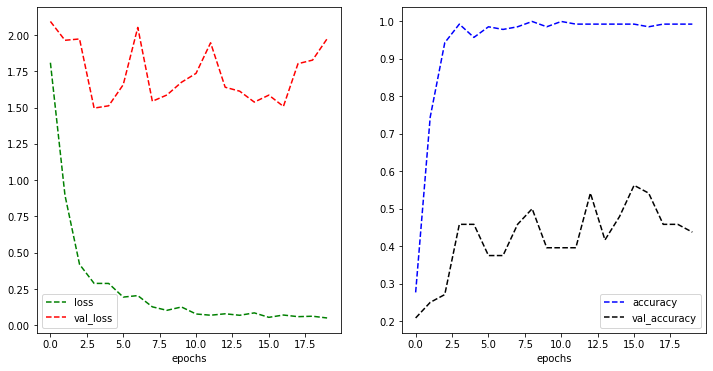

In [111]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],'g--',label='loss')
plt.plot(history.history['val_loss'],'r--',label='val_loss')
plt.xlabel('epochs')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],'b--',label='accuracy')
plt.plot(history.history['val_accuracy'],'k--',label='val_accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

앞선 vggnet은 사전학습이 안된 것에 비해 사전학습이 된 mobileNet V2가 accuracy가 1에 근접하여 훨씬 좋은 성능을 보여주었다 